# 1- Introduction

---

<p align="justify">
In this project, I'm using data recorded from my personal iOS smartphone to see if I can make the phone adjust its orientation. The recording lasts for 685 seconds and the average speed is 20 m/s. I made sure to position my phone in the cup holder to minimize any unnecessary noise during recording. This also ensured that the phone stayed at a consistent angle with the car, which is important for our analysis (the phone is with 57 degree from the surface). To get a comprehensive view of the phone's movement, I'm using various sensors available on iOS devices. These sensors include the Global Positioning System (GPS), gyroscope, accelerometer, and magnetometer. Each of these sensors provides different information about how the phone is oriented and moving, helping us build a better algorithm for reorientation. By using all these sensors, my main goal is to create an algorithm that can use azimuth and heading data to adjust the phone's orientation in real-time. This ability could have applications in navigation systems and augmented reality experiences. In this project, I'll carefully analyze and process the sensor data, refine the algorithm, and then test how well it works in reorienting the phone. This project has the potential to improve user experiences in mobile applications and beyond.





*   Frequency of collected sensors are 10 Hz and for the GNSS is 1 Hz like intact dataset.



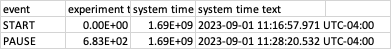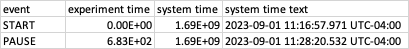

## 1-1- Load the Data

In [1]:
#libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math

import random
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.model_selection import train_test_split
import time
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import max_error
from sklearn.feature_selection import SelectFromModel

In [2]:
#load the data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
acc=pd.read_csv(r'/content/drive/MyDrive/Accelerometer.csv')
gyro=pd.read_csv(r'/content/drive/MyDrive/Gyroscope.csv')
gnss=pd.read_csv(r'/content/drive/MyDrive/Location.csv')
mag=pd.read_csv(r'/content/drive/MyDrive/Magnetometer.csv')


In [ ]:
acc

,Time (s),X (m/s^2),Y (m/s^2),Z (m/s^2)
0,0.002972,0.368683,8.050559,5.652545
1,0.102700,-0.181572,8.217162,5.830825
2,0.202429,-0.248633,8.140222,5.673352
3,0.302157,-0.394280,8.286019,5.861661
4,0.401886,-0.509840,7.955357,5.870642
...,...,...,...,...
6839,682.069646,-0.162562,8.076904,5.622009
6840,682.169378,-0.167202,8.066426,5.599705
6841,682.269111,-0.222887,8.088131,5.600454
6842,682.368842,-0.203427,8.059989,5.587730


In [ ]:
gyro

,Time (s),X (rad/s),Y (rad/s),Z (rad/s)
0,0.080260,-0.013930,-0.001334,0.025469
1,0.179989,-0.023859,0.012863,0.008321
2,0.279717,-0.011634,0.032133,-0.003082
3,0.379446,-0.017894,0.038803,-0.006755
4,0.479174,-0.008915,0.045352,-0.017874
...,...,...,...,...
6839,682.146937,0.000707,0.000970,-0.000020
6840,682.246670,0.000994,-0.000061,0.000217
6841,682.346400,0.000120,-0.000237,0.003559
6842,682.446132,-0.042272,0.002704,0.001963


In [ ]:
gnss

,Time (s),Latitude (°),Longitude (°),Height (m),Velocity (m/s),Direction (°),Horizontal Accuracy (m),Vertical Accuracy (°)
0,0.270161,45.478886,-73.577341,-12.6,14.455889,141.131500,30.0,57.0
1,1.245923,45.478776,-73.577222,-13.3,15.279000,141.334305,30.0,57.0
2,2.247280,45.478661,-73.577095,-13.4,16.102111,141.334305,30.0,57.0
3,3.228210,45.478545,-73.576965,-14.1,16.359333,141.843094,30.0,57.0
4,4.237535,45.478426,-73.576831,-15.7,16.668000,141.635590,30.0,57.0
...,...,...,...,...,...,...,...,...
678,678.236726,45.463885,-73.624348,26.2,0.000000,302.154694,30.0,57.0
679,679.237273,45.463885,-73.624348,26.2,0.000000,302.154694,30.0,57.0
680,680.232446,45.463885,-73.624348,26.2,0.000000,302.154694,30.0,57.0
681,681.267603,45.463885,-73.624348,26.2,0.000000,302.154694,30.0,57.0


In [ ]:
mag

,Time (s),X (µT),Y (µT),Z (µT)
0,0.080260,29.758644,-2.465839,30.732388
1,0.179989,29.263458,-0.900070,30.789463
2,0.279717,29.267776,0.558628,30.988628
3,0.379446,29.289917,1.797371,31.614788
4,0.479174,29.178871,3.081264,32.005131
...,...,...,...,...
6839,682.146937,6.050400,31.502121,2.393448
6840,682.246670,5.963188,31.699238,2.329842
6841,682.346400,6.137009,31.505363,1.971291
6842,682.446132,6.194603,31.498648,2.162781


## 1-2- Data Description and visualization




### 1-2-1- Acceleration

In [ ]:
acc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6844 entries, 0 to 6843
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Time (s)   6844 non-null   float64
 1   X (m/s^2)  6844 non-null   float64
 2   Y (m/s^2)  6844 non-null   float64
 3   Z (m/s^2)  6844 non-null   float64
dtypes: float64(4)
memory usage: 214.0 KB


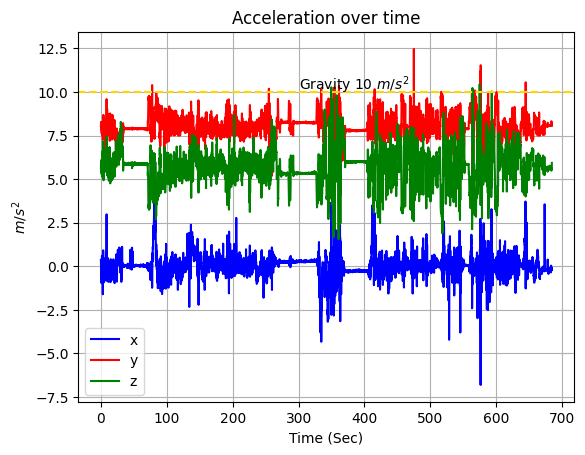

In [ ]:
#Drawing the plot of
t = np.linspace(0, len(acc)/10.0, len(acc))
plt.title('Acceleration over time')
plt.plot( t, acc['X (m/s^2)'], color ='blue')
plt.plot( t, acc['Y (m/s^2)'], color ='red')
plt.plot( t, acc['Z (m/s^2)'], color ='green')
plt.legend(['x', 'y','z'])
plt.axhline(y = 10, color = 'gold', linestyle = '--')
plt.gca().annotate('Gravity 10 $m/s^2$', xy=(300 + 0.1, 10 + 0.1), xycoords='data', fontsize=10)
plt.grid(True)
plt.ylabel("$m/s^2$")
plt.xlabel('Time (Sec)')
plt.show()

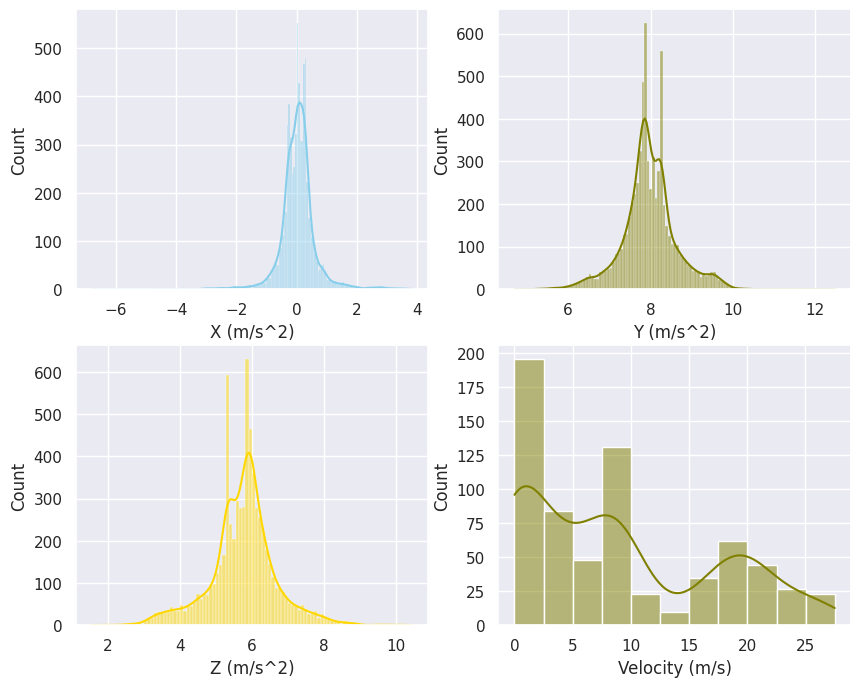

In [ ]:

sns.set(style="darkgrid")

fig, axs = plt.subplots(2, 2, figsize=(10, 8))

sns.histplot(data=acc, x='X (m/s^2)', kde=True, color="skyblue", ax=axs[0, 0])
sns.histplot(data=acc, x='Y (m/s^2)', kde=True, color="olive", ax=axs[0, 1])
sns.histplot(data=acc, x='Z (m/s^2)', kde=True, color="gold", ax=axs[1, 0])
sns.histplot(data=gnss, x='Velocity (m/s)', kde=True, color="olive", ax=axs[1, 1])

plt.show()

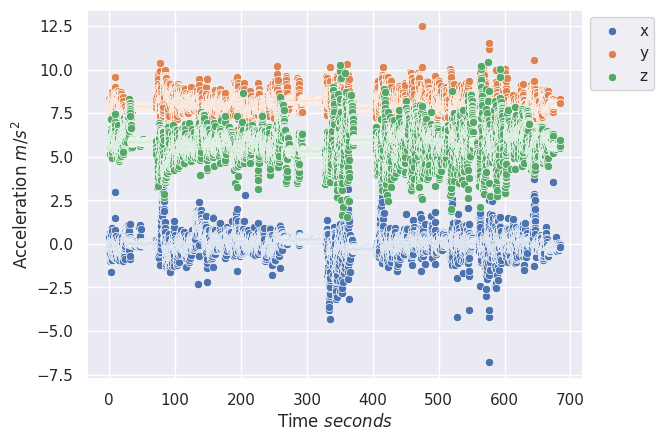

In [ ]:
t = np.linspace(0, len(acc)/10.0, len(acc))
ax=sns.scatterplot(data=acc, x=t, y='X (m/s^2)')
ax=sns.scatterplot(data=acc, x=t, y='Y (m/s^2)')
ax= sns.scatterplot(data=acc, x=t, y='Z (m/s^2)')

ax.set(xlabel='Time $seconds$', ylabel='Acceleration $m/s^2$')
plt.legend(labels = ['x', 'y', 'z'],loc='upper left', bbox_to_anchor=(1, 1))

**C** : This parameter determines the color of the individual data points in your 3D scatter plot. In your code, it's set to (x + y + z), which means that the color of each data point is determined by the sum of its x, y, and z coordinates.

**α** : This parameter controls the transparency or opacity of the data points in the scatter plot. It's set to 0.8 in your code, which means that each data point will be 80%.


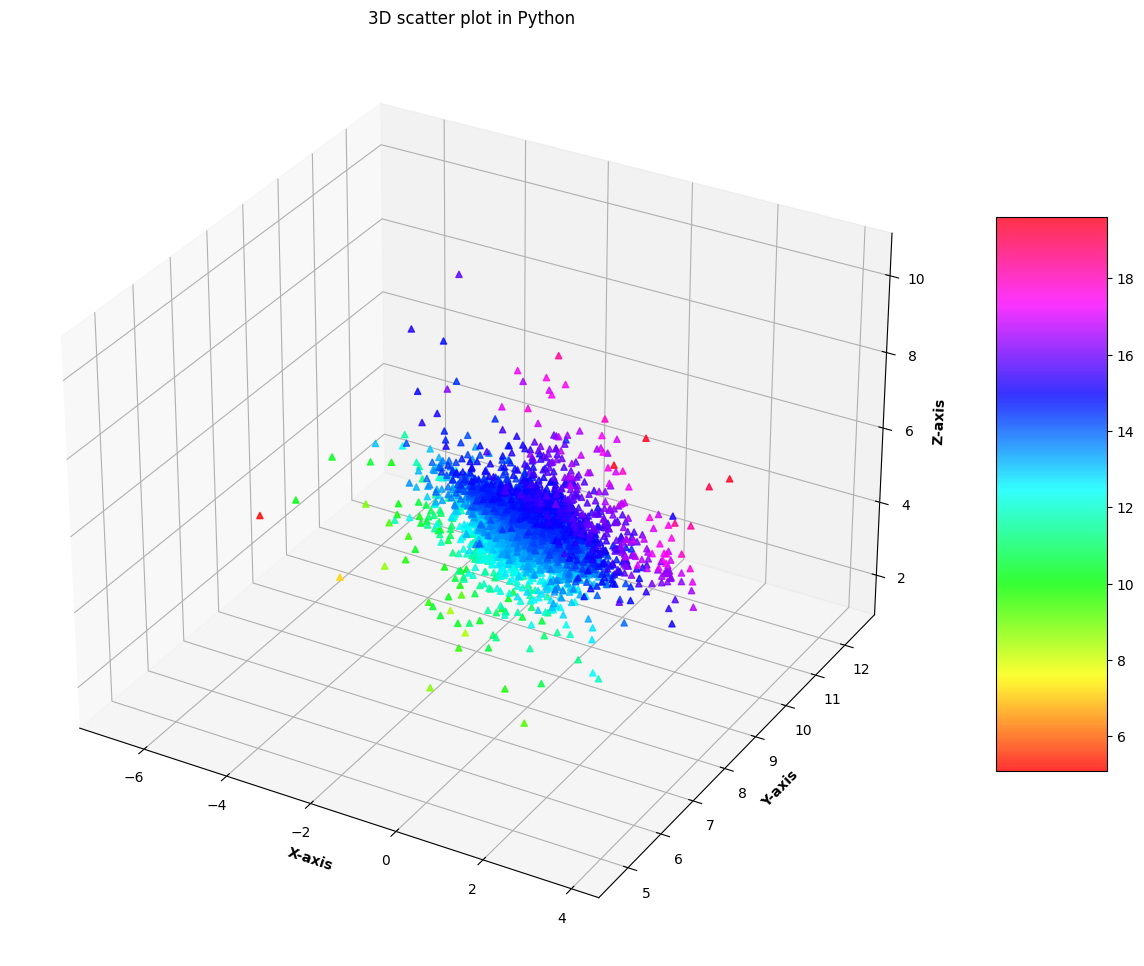

In [ ]:
from pandas.errors import AccessorRegistrationWarning
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import numpy as np


# Creating random dataset
x = acc['X (m/s^2)']
y = acc['Y (m/s^2)']
z = acc['Z (m/s^2)']

# Creating figure
fig = plt.figure(figsize = (16, 12))
ax = plt.axes(projection ="3d")

# Add x, and y gridlines for the figure

# plot the plane

# Creating the color map for the plot
my_cmap = plt.get_cmap('hsv')

# Creating the 3D plot
sctt = ax.scatter3D(x, y, z, alpha = 0.8, c = (x + y + z), cmap = my_cmap,marker ='^')

plt.title("3D scatter plot in Python")
ax.set_xlabel('X-axis', fontweight ='bold')
ax.set_ylabel('Y-axis', fontweight ='bold')
ax.set_zlabel('Z-axis', fontweight ='bold')
fig.colorbar(sctt, ax = ax, shrink = 0.6, aspect = 5)

# display the plot
plt.show()


[Text(0.5, 0, 'Acceleration x'), Text(0, 0.5, ' $m/s^2$ ')]

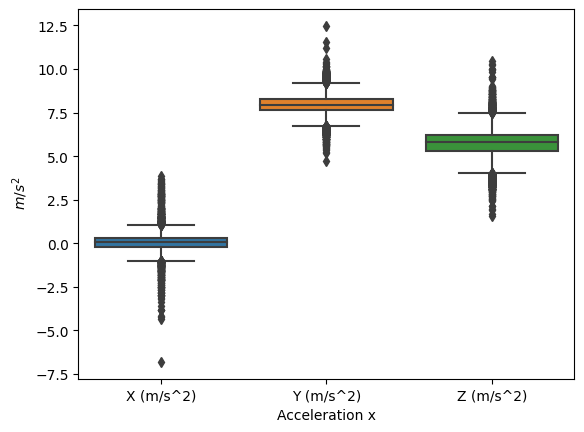

In [ ]:
sns.boxplot(data=acc[['X (m/s^2)','Y (m/s^2)','Z (m/s^2)']],dodge=False).set(
    xlabel='Acceleration x',
    ylabel =' $m/s^2$ '
)

Text(0.5, 1.0, 'Correlation heatmap')

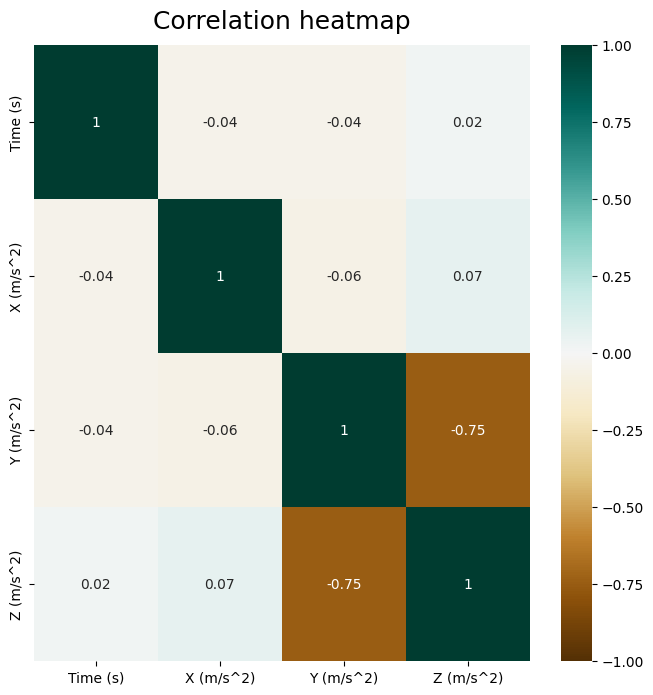

In [ ]:
#Correlation of acceleration
plt.figure(figsize=(8,8))
correlations = acc.corr()
heatmap= sns.heatmap(round(correlations,2), cmap='BrBG', annot=True, annot_kws={"size": 10}, vmin=-1, vmax=1)
heatmap.set_title('Correlation heatmap', fontdict={'fontsize':18}, pad= 12)

### 1-2-2- GNSS

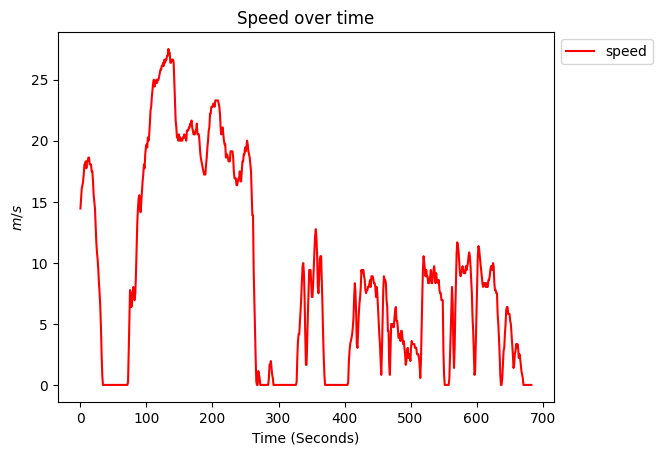

In [ ]:
#Drawing the plot of speed
t = np.linspace(0, len(gnss)/1.0, len(gnss))
plt.title('Speed over time')
plt.plot( t, gnss['Velocity (m/s)'], color ='red')

plt.ylabel('$m/s$')
plt.xlabel('Time (Seconds)')
plt.legend(labels = ['speed'],loc='upper left', bbox_to_anchor=(1, 1))

plt.show()

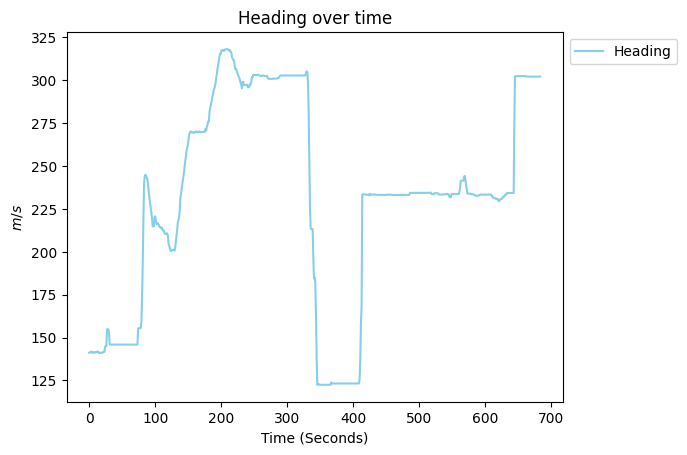

In [ ]:
#Drawing the plot of speed
t = np.linspace(0, len(gnss)/1.0, len(gnss))
plt.title('Heading over time')
plt.plot( t, gnss['Direction (°)'], color ='skyblue')

plt.ylabel('$m/s$')
plt.xlabel('Time (Seconds)')
plt.legend(labels = ['Heading'],loc='upper left', bbox_to_anchor=(1, 1))

plt.show()

In [4]:
import plotly.express as px
import pandas as pd


geo=pd.DataFrame()
geo['Lat'] = gnss['Latitude (°)']
geo['Long'] = gnss['Longitude (°)']
geo['speed']=gnss['Velocity (m/s)']

#geo.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)

#color_scale = [(0, 'orange'), (1,'red')]
#size="car_hours" this two varible could changed for color scale and size of dot points
fig = px.scatter_mapbox(geo,
                        lat="Lat",
                        lon="Long",
                        color_continuous_scale=px.colors.cyclical.IceFire,
                        color="speed",
                        zoom=10,
                        height=800,
                        width=800)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

### 1-2-3- Magnetometer and Gyro

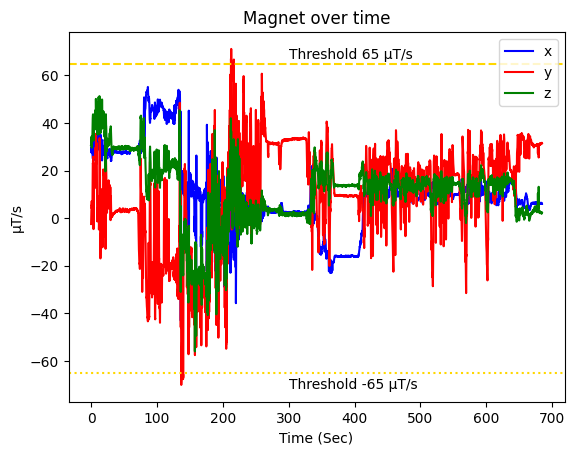

In [ ]:
t = np.linspace(0, len(mag)/10.0, len(mag))
plt.title('Magnet over time')
plt.plot( t, mag['X (µT)'], color ='blue')
plt.plot( t, mag['Y (µT)'], color ='red')
plt.plot( t, mag['Z (µT)'], color ='green')
plt.axhline(y = 65, color = 'gold', linestyle = '--')
plt.axhline(y = -65, color = 'gold', linestyle = ':')
plt.gca().annotate('Threshold 65 \u03bcT/s', xy=(300 + 0.1, 67 + 0.1), xycoords='data', fontsize=10)
plt.gca().annotate('Threshold -65 \u03bcT/s', xy=(300 + 0.1, -72 + 0.1), xycoords='data', fontsize=10)
plt.legend(['x', 'y','z'])

plt.ylabel(u"\u03bcT/s")
plt.xlabel('Time (Sec)')
plt.show()

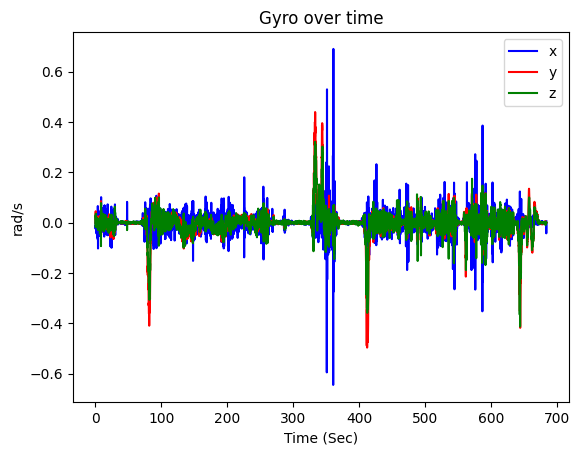

In [ ]:
t = np.linspace(0, len(gyro)/10.0, len(gyro))
plt.title('Gyro over time')
plt.plot( t, gyro['X (rad/s)'], color ='blue')
plt.plot( t, gyro['Y (rad/s)'], color ='red')
plt.plot( t, gyro['Z (rad/s)'], color ='green')

plt.legend(['x', 'y','z'])

plt.ylabel("rad/s")
plt.xlabel('Time (Sec)')
plt.show()

# 2- Data preprocessing

In this section merge the sensor and scaale of up the gnss data to match the rest of the dataset. Also, I would apply Normalization on the dataset.

In [ ]:
geo.describe()

,Lat,Long,speed,heading,time,delta
count,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000
mean,45.469806,-73.603149,8.962707,231.686499,341.225226,-0.021165
std,0.003894,0.016272,8.164336,60.039751,197.310000,0.869896
min,45.463464,-73.624348,0.000000,122.383789,0.270161,-4.475667
25%,45.466347,-73.613616,1.389000,210.506165,170.711848,-0.308667
50%,45.469983,-73.609578,7.510889,233.440491,341.205556,0.000000
75%,45.473091,-73.590727,16.925222,297.306152,511.754558,0.257222
max,45.478886,-73.573395,27.522778,318.300000,682.218054,3.086667


In [6]:
geo['heading']= gnss['Direction (°)']
geo['time']=gnss['Time (s)']


In [5]:
#Estimating the delta after merging
geo['delta']=geo['speed'].diff()
geo=geo.fillna(0)

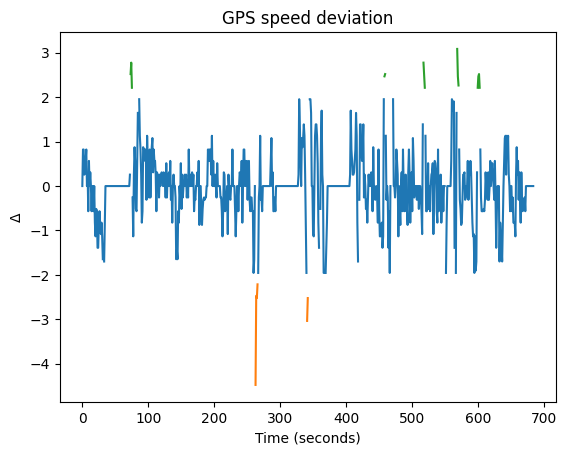

In [ ]:
#This graph show when the acceleration are

t = np.linspace(0, len(geo)/1.0, len(geo))

s=geo['delta']
# plot input vs output

upper = 2
lower = -2

supper = np.ma.masked_where(s < upper, s)
slower = np.ma.masked_where(s > lower, s)
smiddle = np.ma.masked_where((s < lower) | (s > upper), s)

fig, ax = plt.subplots()
ax.plot(t, smiddle, t, slower, t, supper)


plt.title('GPS speed deviation')
plt.xlabel('Time (seconds)')
plt.ylabel(u'Δ')
plt.show()

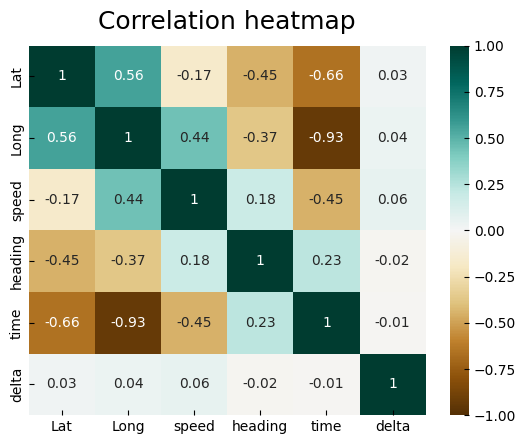

In [ ]:
#Correlation of gnss
correlations = geo.corr()
heatmap= sns.heatmap(round(correlations,2), cmap='BrBG', annot=True, annot_kws={"size": 10}, vmin=-1, vmax=1)
heatmap.set_title('Correlation heatmap', fontdict={'fontsize':18}, pad= 12)
plt.grid(False)

In [7]:
dt= pd.DataFrame()
dt['time'] = round(acc['Time (s)'].astype(float),1)
dt['Acc_x'] = round(acc['X (m/s^2)'].astype(float),3)
dt['Acc_y'] = round(acc['Y (m/s^2)'].astype(float),3)
dt['Acc_z'] = round(acc['Z (m/s^2)'].astype(float),3)

In [ ]:
dt

,time,Acc_x,Acc_y,Acc_z
0,0.0,0.369,8.051,5.653
1,0.1,-0.182,8.217,5.831
2,0.2,-0.249,8.140,5.673
3,0.3,-0.394,8.286,5.862
4,0.4,-0.510,7.955,5.871
...,...,...,...,...
6839,682.1,-0.163,8.077,5.622
6840,682.2,-0.167,8.066,5.600
6841,682.3,-0.223,8.088,5.600
6842,682.4,-0.203,8.060,5.588


In [8]:
dgps= pd.DataFrame()
dgps['time'] = round(geo['time'].astype(float),1)
dgps['speed'] = round(geo['speed'].astype(float),3)
dgps['heading'] = round(geo['heading'].astype(float),3)
dgps['delta'] = round(geo['delta'].astype(float),3)

In [ ]:
dgps

,time,speed,heading,delta
0,0.3,14.456,141.132,0.000
1,1.2,15.279,141.334,0.823
2,2.2,16.102,141.334,0.823
3,3.2,16.359,141.843,0.257
4,4.2,16.668,141.636,0.309
...,...,...,...,...
678,678.2,0.000,302.155,0.000
679,679.2,0.000,302.155,0.000
680,680.2,0.000,302.155,0.000
681,681.3,0.000,302.155,0.000


In [9]:
df= pd.merge(dt, dgps, on='time',how='outer')
df

,time,Acc_x,Acc_y,Acc_z,speed,heading,delta
0,0.0,0.369,8.051,5.653,NaN,NaN,NaN
1,0.1,-0.182,8.217,5.831,NaN,NaN,NaN
2,0.2,-0.249,8.140,5.673,NaN,NaN,NaN
3,0.3,-0.394,8.286,5.862,14.456,141.132,0.0
4,0.4,-0.510,7.955,5.871,NaN,NaN,NaN
...,...,...,...,...,...,...,...
6839,682.1,-0.163,8.077,5.622,NaN,NaN,NaN
6840,682.2,-0.167,8.066,5.600,0.000,302.155,0.0
6841,682.3,-0.223,8.088,5.600,NaN,NaN,NaN
6842,682.4,-0.203,8.060,5.588,NaN,NaN,NaN


Polynomial interpolation is a method of approximating a set of data points using a polynomial function. The goal is to find a polynomial equation that passes through all the data points while minimizing the error between the polynomial curve and the actual data.

*Order or Degree of the Polynomial:*

The order parameter, in this case set to 2, determines the degree of the polynomial to be used for interpolation. A polynomial of degree 2 is also known as a quadratic polynomial. It has the form:

$f(x)=ax^2+bx+c$

Here, 'a', 'b', and 'c' are coefficients that the interpolation method will determine to fit the data.

In [10]:
df['delta'] = df['delta'].interpolate(method='polynomial',order=2)
df['heading'] = df['heading'].interpolate(method='polynomial',order=2)
df['speed'] = df['speed'].interpolate(method='polynomial',order=2)

In [11]:
df['delta'] = df['delta'].fillna(method='ffill')
df['heading'] = df['heading'].fillna(method='ffill')
df['speed'] = df['speed'].fillna(method='ffill')

In [12]:
df['delta'] = df['delta'].fillna(method='bfill')
df['heading'] = df['heading'].fillna(method='bfill')
df['speed'] = df['speed'].fillna(method='bfill')

In [ ]:
df

,time,Acc_x,Acc_y,Acc_z,speed,heading,delta
0,0.0,0.369,8.051,5.653,0.000000e+00,141.000000,0.000000e+00
1,0.1,-0.182,8.217,5.831,0.000000e+00,141.000000,0.000000e+00
2,0.2,-0.249,8.140,5.673,0.000000e+00,141.000000,0.000000e+00
3,0.3,-0.394,8.286,5.862,1.445600e+01,141.132000,0.000000e+00
4,0.4,-0.510,7.955,5.871,1.454713e+01,141.170923,1.312667e-01
...,...,...,...,...,...,...,...
6839,682.1,-0.163,8.077,5.622,1.156800e-10,302.155000,6.996089e-10
6840,682.2,-0.167,8.066,5.600,0.000000e+00,302.155000,0.000000e+00
6841,682.3,-0.223,8.088,5.600,0.000000e+00,302.155000,0.000000e+00
6842,682.4,-0.203,8.060,5.588,0.000000e+00,302.155000,0.000000e+00


In [13]:
df.isna().sum()

time       0
Acc_x      0
Acc_y      0
Acc_z      0
speed      0
heading    0
delta      0
dtype: int64

# 3- Method 1: 3D dimenation reorientation

**getOrientation** : This method computes the orientation angles (azimuth, pitch, and roll) from a given rotation matrix. It takes in two parameters: R (the rotation matrix) and values (an array to store the resulting orientation angles).

The method utilizes trigonometric calculations to extract the orientation angles from the rotation matrix. The resulting angles are in radians and represent the device's azimuth (rotation around the Z-axis), pitch (rotation around the X-axis), and roll (rotation around the Y-axis).

The computed orientation angles are stored in the values array, with the azimuth angle at index 0, pitch at index 1, and roll at index 2.

        Python implementation of the getOrientation method from Android's API, as presented in
        https://can01.safelinks.protection.outlook.com/?url=https%3A%2F%2Fandroid.googlesource.com%2Fplatform%2Fframeworks%2Fbase%2F%2B%2Fmaster%2Fcore%2Fjava%2Fandroid%2Fhardware%2FSensorManager.java&amp;data=05%7C01%7Cmohammad.ghavidel%40intact.net%7C26ca106b04a546ef128708dad9eae652%7Cb880eecaf1fb4c91bff682e84350a6e6%7C0%7C0%7C638061900165893431%7CUnknown%7CTWFpbGZsb3d8eyJWIjoiMC4wLjAwMDAiLCJQIjoiV2luMzIiLCJBTiI6Ik1haWwiLCJXVCI6Mn0%3D%7C3000%7C%7C%7C&amp;sdata=pTgNvHa2aELr%2F5lIdnwEA0YCeABiWOci4Mpn7kdPj2U%3D&amp;reserved=0
        

**get_azimuth** is getting the acceleramter to calculate Azimuth



1.   Magnetic declination, often referred to simply as 'declination,' represents the angle by which a compass deviates from pointing towards true north. This phenomenon has posed challenges to navigators for centuries, primarily due to its variability based on geographical location and temporal changes.
2.   Magnetic declination is indeed dependent on geographical location, and for the city of Montreal, it is approximately -13.5 degrees.

That why I add -13.5 as adjustment to the formula



In [ ]:
def get_azimuth(acc_x, acc_y, acc_z, mag_x, mag_y, mag_z):
    declination = -13.5
    azimuth = []
    R = []
    I = []
    for i in range(0, len(acc_x)):
        accs=(acc_x[i], acc_y[i], acc_z[i])
        mags=(mag_x[i], mag_y[i], mag_z[i])
        R,I = getRotationMatrix(accs,mags)
        azimuth.append(np.degrees(np.arctan2(R[1], R[5])) + declination)

    return azimuth

getRotationMatrix(): This method calculates a rotation matrix based on gravity and geomagnetic sensor values. It takes in four parameters: R (output rotation matrix), I (output inclination matrix), gravity (an array containing gravity sensor values), and geomagnetic (an array containing geomagnetic sensor values).

The method first checks the magnitude of the gravity vector to determine if the device is in free fall or close to the magnetic north pole. If the gravity is below a certain threshold, it returns false to indicate that the rotation matrix cannot be calculated accurately.

If the gravity is within the expected range, the method proceeds to calculate the rotation matrix. It involves various vector operations and normalization to determine the orientation of the device relative to the Earth's magnetic field. The resulting rotation matrix is stored in the R array.

Additionally, if the I parameter is not null, the method computes an inclination matrix based on the geomagnetic vector. The inclination matrix represents the tilt of the device with respect to the Earth's surface. The calculated inclination matrix is stored in the I array.

The method returns true to indicate that the rotation matrix and, optionally, the inclination matrix have been successfully calculated.

In [ ]:
def getRotationMatrix(gravity, geomagnetic):


        Ax = gravity[0]
        Ay = gravity[1]
        Az = gravity[2]
        normsqA = (Ax * Ax + Ay * Ay + Az * Az)
        g = 9.81
        freeFallGravitySquared = 0.01 * g * g

        if normsqA < freeFallGravitySquared:
                # gravity less than 10% of normal value
               return False

        Ex = geomagnetic[0]
        Ey = geomagnetic[1]
        Ez = geomagnetic[2]
        Hx = Ey * Az - Ez * Ay
        Hy = Ez * Ax - Ex * Az
        Hz = Ex * Ay - Ey * Ax

        normH = np.sqrt(Hx * Hx + Hy * Hy + Hz * Hz)

        if normH < 0.1:
                # device is close to free fall (or in space?), or close to
                 #magnetic north pole. Typical values are  > 100.
                return False

        invH = 1.0 / normH
        Hx *= invH
        Hy *= invH
        Hz *= invH

        invA = 1.0 / np.sqrt(Ax * Ax + Ay * Ay + Az * Az)
        Ax *= invA
        Ay *= invA
        Az *= invA

        Mx = Ay * Hz - Az * Hy
        My = Az * Hx - Ax * Hz
        Mz = Ax * Hy - Ay * Hx

        R = np.zeros(9)

        R[0] = Hx;     R[1] = Hy;     R[2] = Hz
        R[3] = Mx;     R[4] = My;     R[5] = Mz
        R[6] = Ax;     R[7] = Ay;     R[8] = Az



        invE = 1.0 / np.sqrt(Ex * Ex + Ey * Ey + Ez * Ez)
        c = (Ex * Mx + Ey * My + Ez * Mz) * invE
        s = (Ex * Ax + Ey * Ay + Ez * Az) * invE

        I = np.zeros(9)

        I[0] = 1;     I[1] = 0;     I[2] = 0;
        I[3] = 0;     I[4] = c;     I[5] = s;
        I[6] = 0;     I[7] = -s;    I[8] = c;



        return R, I

**def getOrientation(R):**

        values = np.zeros(3)
        values[0] = np.arctan2((R[1], (R[5])
        values[1] = np.arcsin(-R[7])
        values[2] = np.arctan2(-R[6], R[8])

        return values[0]


**def get_inclination(I):**

    if len(I) == 9:
        return math.atan2(I[5], I[4])
    else:
        return math.atan2(I[6], I[5])

In [14]:
def flat_reorientation(X,Y,Z, phi=0 ):

        xm = np.median(X)
        ym = np.median(Y)
        zm = np.median(Z)

        g = np.sqrt(xm**2 + ym**2 + zm**2)

        alpha = np.arcsin(xm/g)
        beta  = np.arcsin(ym/g)

        phi *= -1

        ca = np.cos(alpha)
        sa = np.sin(alpha)
        cb = np.cos(beta)
        sb = np.sin(beta)
        cp = np.cos(phi)
        sp = np.sin(phi)

        l = list(map(
                lambda x,y,z: [
                        y*cb*sp + z*(-cp*sa -ca*sb*sp) + x*(ca*cp -sa*sb*sp),
                        y*cb*cp + x*(-cp*sa*sb -ca*sp) + z*(sa*sp -ca*cp*sb),
                        z*ca*cb + x*sa*cb + y*sb
                ],
                X,Y,Z
        ))

        return np.array(l)

In [ ]:
#Reorient the  raw sensors
azimuth = get_azimuth(
        acc['X (m/s^2)'], acc['Y (m/s^2)'], acc['Z (m/s^2)'],
        mag['X (µT)'], mag['Y (µT)'], mag['Z (µT)']
)

In [15]:
# change pyplot style
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.signal
import math
plt.style.use('bmh')
#the window is chosen based on frequency of sensor 10 Hz and for the sma filter half of this size is recommended

def sma_filter(l, w=5):
        return np.convolve(l, np.ones((w,))/w, mode='valid')

def median_filter(l, w=11):
        return scipy.signal.medfilt(l, w)

def pm_180(l):
        """ Change range from [0,360) to [-180,180] """
        return np.array([ v if v<=180 else v-360 for v in l ])

In [ ]:
#smoothing the heading and azmuth with 11 window (based on 10 Hz frequency)

azimuth = median_filter(azimuth)

heading = median_filter(df['heading'])
heading = pm_180(heading)


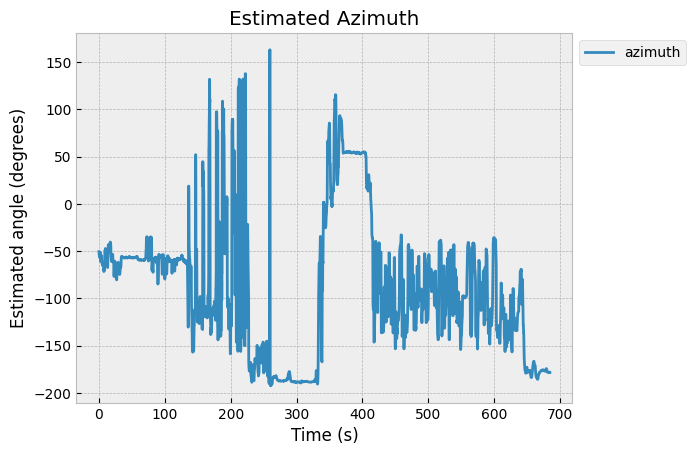

In [ ]:
t = np.linspace(0, len(azimuth)/10.0, len(azimuth))

plt.title('Estimated Azimuth')
plt.plot( t, (azimuth), label='azimuth')
plt.ylabel('Estimated angle (degrees)')
plt.xlabel('Time (s)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [ ]:
#yaw would be diffrence between heading and azimuth
yaw = heading - azimuth
yaw = pm_180(yaw)
median_azimuth = np.median(azimuth)
median_heading=np.median(heading)

In [ ]:
median_yaw = np.median(yaw)
median_yaw

-5.877642682740536

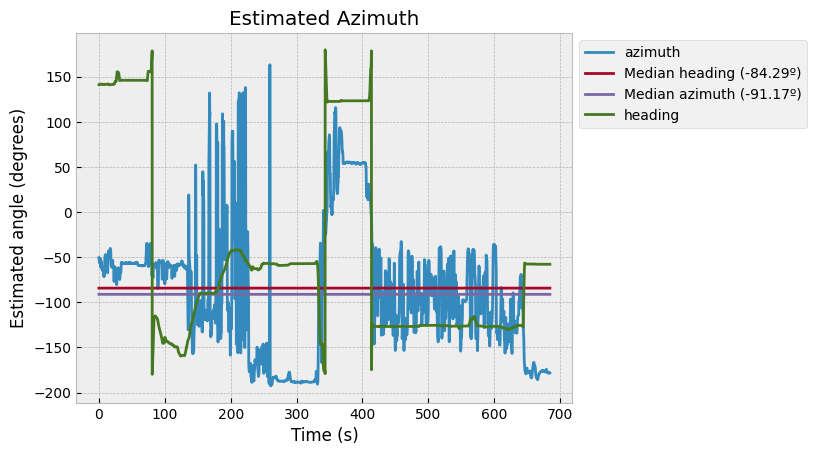

In [ ]:
t = np.linspace(0, len(azimuth)/10.0, len(azimuth))

plt.title('Estimated Azimuth')
plt.plot( t, (azimuth), label='azimuth')
plt.plot( t, [median_heading]*len(azimuth), label='Median heading (%.2fº)'%(median_heading) )
plt.plot( t, [median_azimuth]*len(azimuth), label='Median azimuth (%.2fº)'%(median_azimuth) )

plt.plot( t, heading, label='heading')
plt.ylabel('Estimated angle (degrees)')
plt.xlabel('Time (s)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

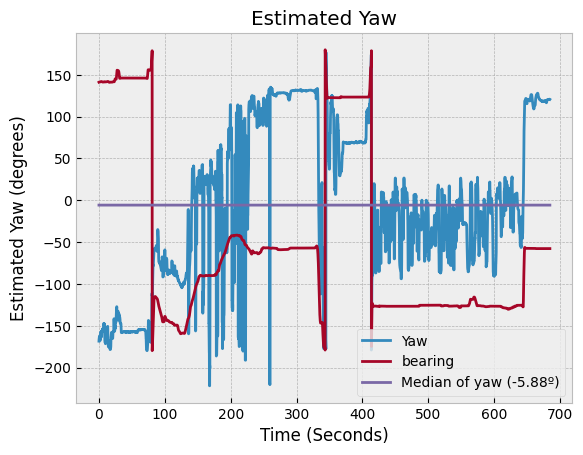

In [ ]:
t = np.linspace(0, len(azimuth)/10.0, len(azimuth))

plt.title('Estimated Yaw')
plt.plot( t, yaw, label='Yaw')
plt.plot( t, heading, label='bearing')
plt.plot( t, [median_yaw]*len(azimuth), label='Median of yaw (%.2fº)'%(median_yaw) )
plt.ylabel('Estimated Yaw (degrees)')
plt.xlabel('Time (Seconds)')
plt.legend()
plt.show()

In [ ]:
#Reorientation based on phi angel of yaw
r = flat_reorientation(acc['X (m/s^2)'], acc['Y (m/s^2)'], acc['Z (m/s^2)'],np.radians(median_yaw))
dr=pd.DataFrame(r)
dr.columns = ['racc_x','racc_y', 'racc_z']
#Total acceleration after reorientation
dr['racc_total']=np.sqrt(dr['racc_z']**2+ dr['racc_x']**2 + dr['racc_y']**2)

In [ ]:
dr=pd.DataFrame(r)
dr.columns = ['racc_x','racc_y', 'racc_z']
#Total acceleration after reorientation
dr['racc_total']=np.sqrt(dr['racc_z']**2+ dr['racc_x']**2 + dr['racc_y']**2)

In [24]:
df['total']=np.sqrt(df['Acc_z']**2+ df['Acc_x']**2 + df['Acc_y']**2)

In [ ]:
dr['Acc_x']  = df['Acc_x']
dr['Acc_y']  = df['Acc_y']
dr['Acc_z']  = df['Acc_z']
dr['delta']  = df['delta']
dr['total']= df['total']
dr['speed']  = df['speed']
dr['time'] = df ['time']
dr['time'] = df ['time']


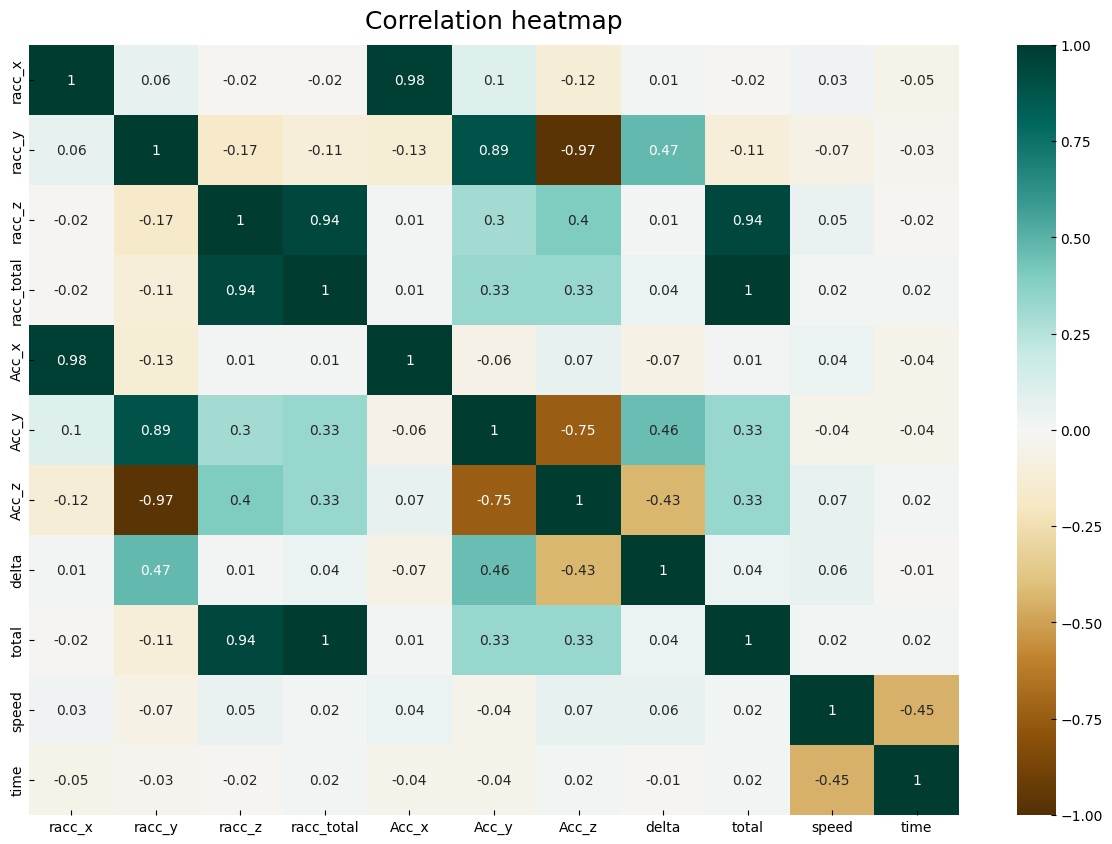

In [ ]:
#correlation of parameters after reoreintation with yaw as a varible
plt.figure(figsize=(15,10))
correlations = dr.corr()
heatmap= sns.heatmap(round(correlations,2), cmap='BrBG', annot=True, annot_kws={"size": 10}, vmin=-1, vmax=1)
heatmap.set_title('Correlation heatmap', fontdict={'fontsize':18}, pad= 12)
plt.grid(False)

## 3-1- Test the methodology

[Text(0.5, 0, 'Acceleration x'), Text(0, 0.5, ' $m/s^2$ ')]

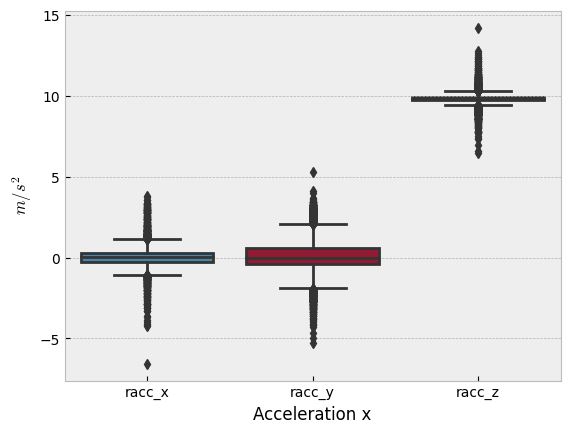

In [ ]:
sns.boxplot(data=dr[['racc_x','racc_y','racc_z']],dodge=False).set(
    xlabel='Acceleration x',
    ylabel =' $m/s^2$ '
)

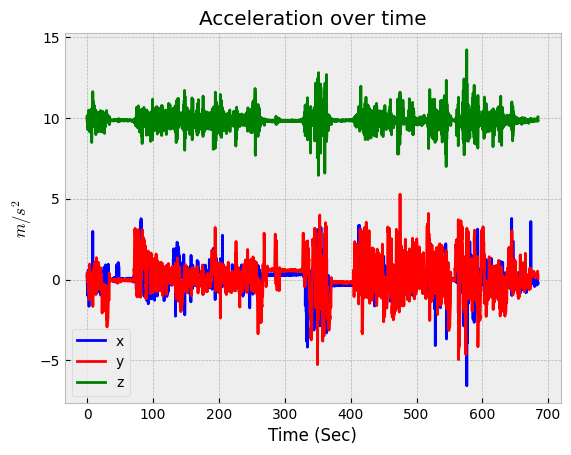

In [ ]:
#Drawing the plot of
t = np.linspace(0, len(dr)/10.0, len(dr))
plt.title('Acceleration over time')
plt.plot( t, dr['racc_x'], color ='blue')
plt.plot( t, dr['racc_y'], color ='red')
plt.plot( t, dr['racc_z'], color ='green')
plt.legend(['x', 'y','z'])

plt.ylabel("$m/s^2$")
plt.xlabel('Time (Sec)')
plt.show()

# 4- Method 2: only using Accelerometer

First find the median of each dimention x, y, z then calculate the g as the total acceleration:

$x_m = median(X)$

$y_m = median(Y)$

$z_m = median(Z)$   

we would use the median and g to normalized the value.

g is would be total acceleration value $m/s^2$

$g = \sqrt{(x_m^2 + y_m^2 + z_m^2)}$

$\alpha = \arccos(\frac{y_m}{z_m})$

$\beta  = \arctan(\frac{x_m}{\sqrt {y_m^2 + Z_m^2}})$
    
$\phi = \arctan(\frac{(-x_m*sin(\beta) +y_m*cos(\beta))}{(x_m*cos(\beta)+y_m*sin(\beta)-z_m*sin(\theta)})
$

In [ ]:
df

,time,Acc_x,Acc_y,Acc_z,speed,heading,delta
0,0.0,0.369,8.051,5.653,0.000000e+00,141.000000,0.000000e+00
1,0.1,-0.182,8.217,5.831,0.000000e+00,141.000000,0.000000e+00
2,0.2,-0.249,8.140,5.673,0.000000e+00,141.000000,0.000000e+00
3,0.3,-0.394,8.286,5.862,1.445600e+01,141.132000,0.000000e+00
4,0.4,-0.510,7.955,5.871,1.454713e+01,141.170923,1.312667e-01
...,...,...,...,...,...,...,...
6839,682.1,-0.163,8.077,5.622,1.156800e-10,302.155000,6.996089e-10
6840,682.2,-0.167,8.066,5.600,0.000000e+00,302.155000,0.000000e+00
6841,682.3,-0.223,8.088,5.600,0.000000e+00,302.155000,0.000000e+00
6842,682.4,-0.203,8.060,5.588,0.000000e+00,302.155000,0.000000e+00


In [ ]:
xm = np.median(acc['X (m/s^2)'])
ym = np.median(acc['Y (m/s^2)'])
zm = np.median(acc['Z (m/s^2)'])
g = np.sqrt(xm**2 + ym**2 + zm**2)

In [ ]:
#~Estimating the new accelerameter value only with
def reorientation_new(X,Y,Z):

        xm = np.median(X)
        ym = np.median(Y)
        zm = np.median(Z)

        g = np.sqrt(xm**2 + ym**2 + zm**2)

        alpha = np.arctan(ym/zm)
        beta  = np.arctan(-xm/(np.sqrt(ym+zm)))
        phi = np.arctan((-xm*np.sin(beta) +ym*np.cos(beta))/(xm*np.cos(beta)+ym*np.sin(beta)-zm*np.sin(alpha)))

        ca = np.cos(alpha)
        sa = np.sin(alpha)
        cb = np.cos(beta)
        sb = np.sin(beta)


        l = list(map(
                lambda x,y,z: [
                        y*cb*np.sin(phi) + z*(-np.cos(phi)*sa -ca*sb*np.sin(phi)) + x*(ca*np.cos(phi) -sa*sb*np.sin(phi)),
                        y*cb*np.cos(phi) + x*(-np.cos(phi)*sa*sb -ca*np.sin(phi)) + z*(sa*np.sin(phi) -ca*np.cos(phi)*sb),
                        z*ca*cb + x*sa*cb + y*sb
                ],
                X,Y,Z
        ))

        return np.array(l)

In [ ]:
r_new = reorientation_new(acc['X (m/s^2)'], acc['Y (m/s^2)'], acc['Z (m/s^2)'])


In [ ]:
dr_new=pd.DataFrame(r_new)
dr_new.columns = ['racc_x','racc_y', 'racc_z']

In [ ]:
dr_new['Acc_x']  = df['Acc_x']
dr_new['Acc_y']  = df['Acc_y']
dr_new['Acc_z']  = df['Acc_z']
dr_new['delta']  = df['delta']
dr_new['total']=np.sqrt(df['Acc_z']**2+ df['Acc_x']**2 + df['Acc_y']**2)
dr_new['speed']=df['speed']
dr_new['racc_total']=np.sqrt(dr_new['racc_z']**2+ dr_new['racc_x']**2 + dr_new['racc_y']**2)

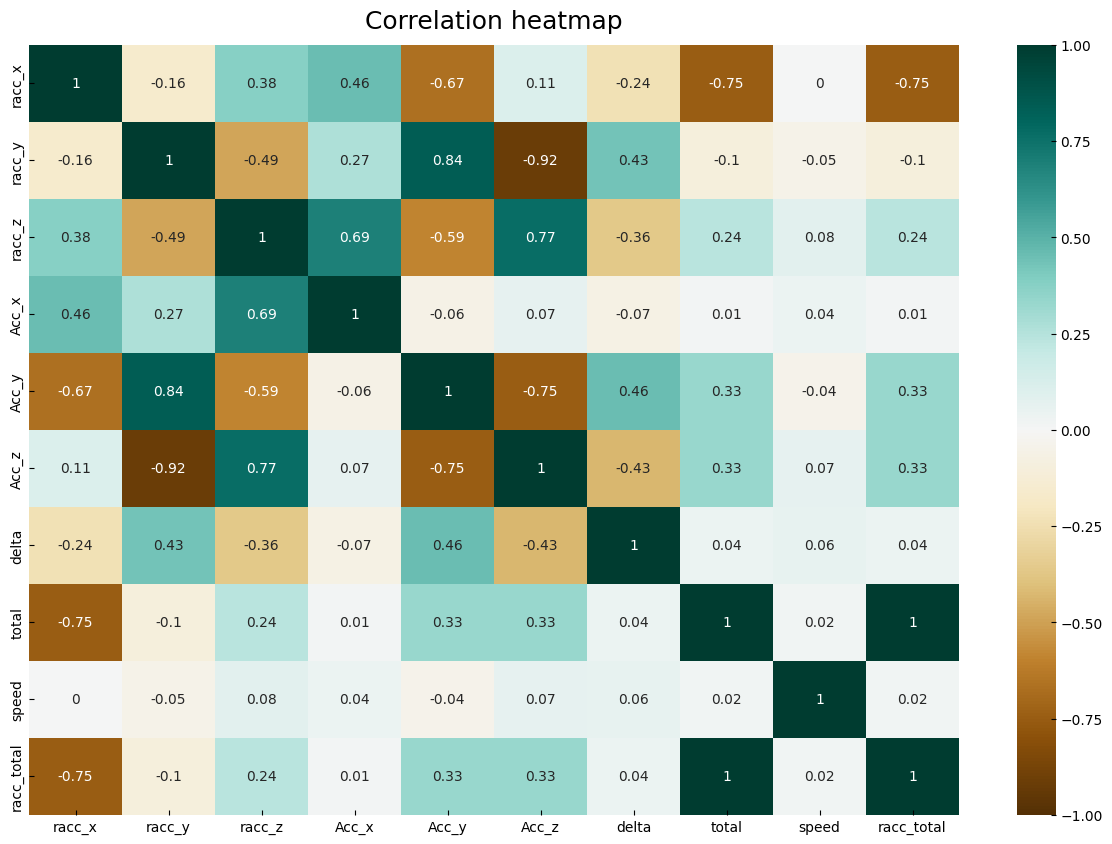

In [ ]:
#correlation of parameters after reoreintation with yaw as a varible
plt.figure(figsize=(15,10))
correlations = dr_new.corr()
heatmap= sns.heatmap(round(correlations,2), cmap='BrBG', annot=True, annot_kws={"size": 10}, vmin=-1, vmax=1)
heatmap.set_title('Correlation heatmap', fontdict={'fontsize':18}, pad= 12)
plt.grid(False)

[Text(0.5, 0, 'Acceleration '), Text(0, 0.5, ' $m/s^2$ ')]

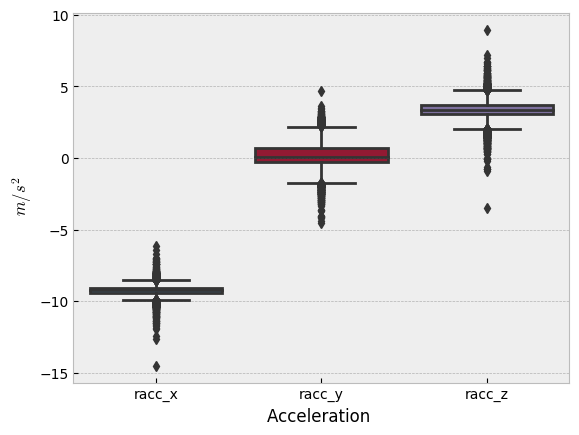

In [ ]:
sns.boxplot(data=dr_new[['racc_x','racc_y','racc_z']],dodge=False).set(
    xlabel='Acceleration ',
    ylabel =' $m/s^2$ '
)

# 5- Method 3- Use only Magnetometer to estimate Azimuth

In [16]:
mag['azimuth']= mag.apply(lambda mag: np.arctan2(float(mag['X (µT)']),float(mag['Y (µT)']))*180/np.pi, axis=1)

In [17]:
azimuth_new = median_filter(mag['azimuth'])
heading = median_filter(df['heading'])
heading = pm_180(heading)

In [18]:
#yaw would be diffrence between heading and azimuth
yaw_new = heading - azimuth_new
yaw_new = pm_180(yaw_new)
median_azimuth = np.median(azimuth_new)
median_yaw_new=np.median(yaw_new)

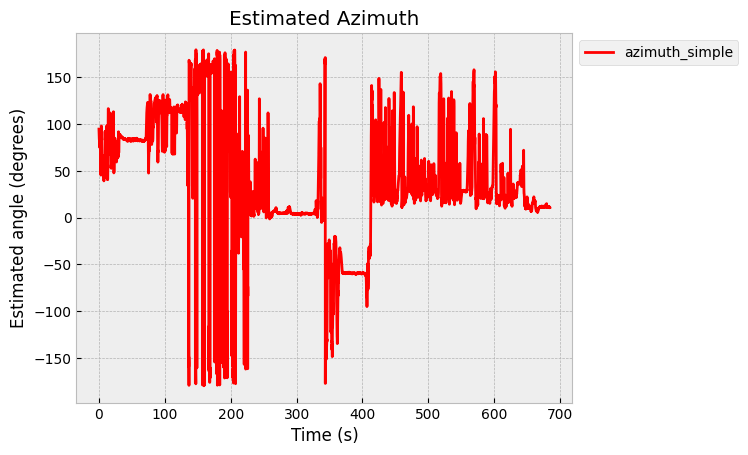

In [ ]:
t = np.linspace(0, len(azimuth)/10.0, len(azimuth))

plt.title('Estimated Azimuth')
plt.plot( t, mag['azimuth'], label='azimuth_simple',color='red')
plt.ylabel('Estimated angle (degrees)')
plt.xlabel('Time (s)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

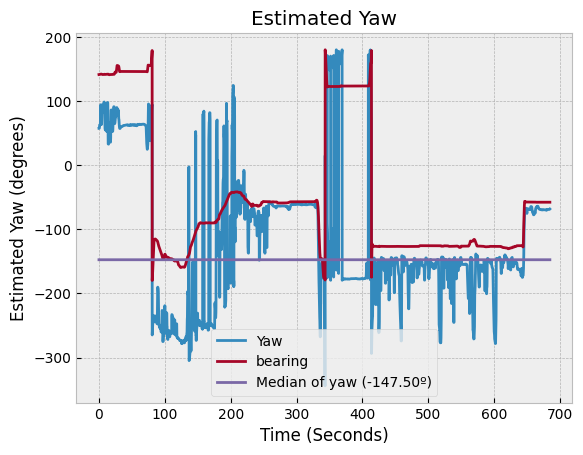

In [19]:
t = np.linspace(0, len(azimuth_new)/10.0, len(azimuth_new))

plt.title('Estimated Yaw')
plt.plot( t, yaw_new, label='Yaw')
plt.plot( t, heading, label='bearing')
plt.plot( t, [median_yaw_new]*len(azimuth_new), label='Median of yaw (%.2fº)'%(median_yaw_new) )
plt.ylabel('Estimated Yaw (degrees)')
plt.xlabel('Time (Seconds)')
plt.legend()
plt.show()

In [22]:
#Reorientation based on phi angel of yaw
r_simple = flat_reorientation(acc['X (m/s^2)'], acc['Y (m/s^2)'], acc['Z (m/s^2)'],np.radians(median_yaw_new))
dr_simple=pd.DataFrame(r_simple)
dr_simple.columns = ['racc_x','racc_y', 'racc_z']
#Total acceleration after reorientation
dr_simple['racc_total']=np.sqrt(dr_simple['racc_z']**2+ dr_simple['racc_x']**2 + dr_simple['racc_y']**2)

In [25]:
dr_simple['Acc_x']  = df['Acc_x']
dr_simple['Acc_y']  = df['Acc_y']
dr_simple['Acc_z']  = df['Acc_z']
dr_simple['delta']  = df['delta']
dr_simple['total']= df['total']
dr_simple['speed']  = df['speed']
dr_simple['time'] = df ['time']


[Text(0.5, 0, 'Acceleration x'), Text(0, 0.5, ' $m/s^2$ ')]

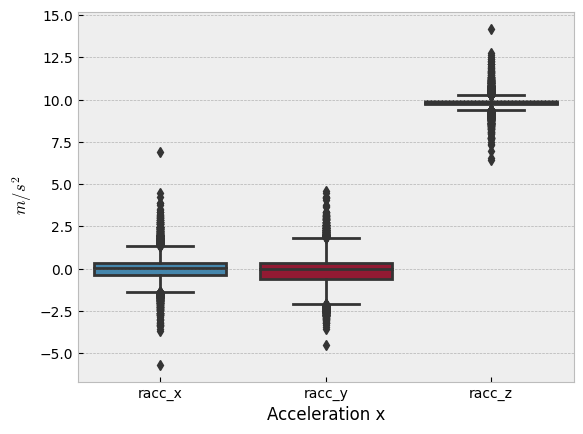

In [26]:
sns.boxplot(data=dr_simple[['racc_x','racc_y','racc_z']],dodge=False).set(
    xlabel='Acceleration x',
    ylabel =' $m/s^2$ '
)

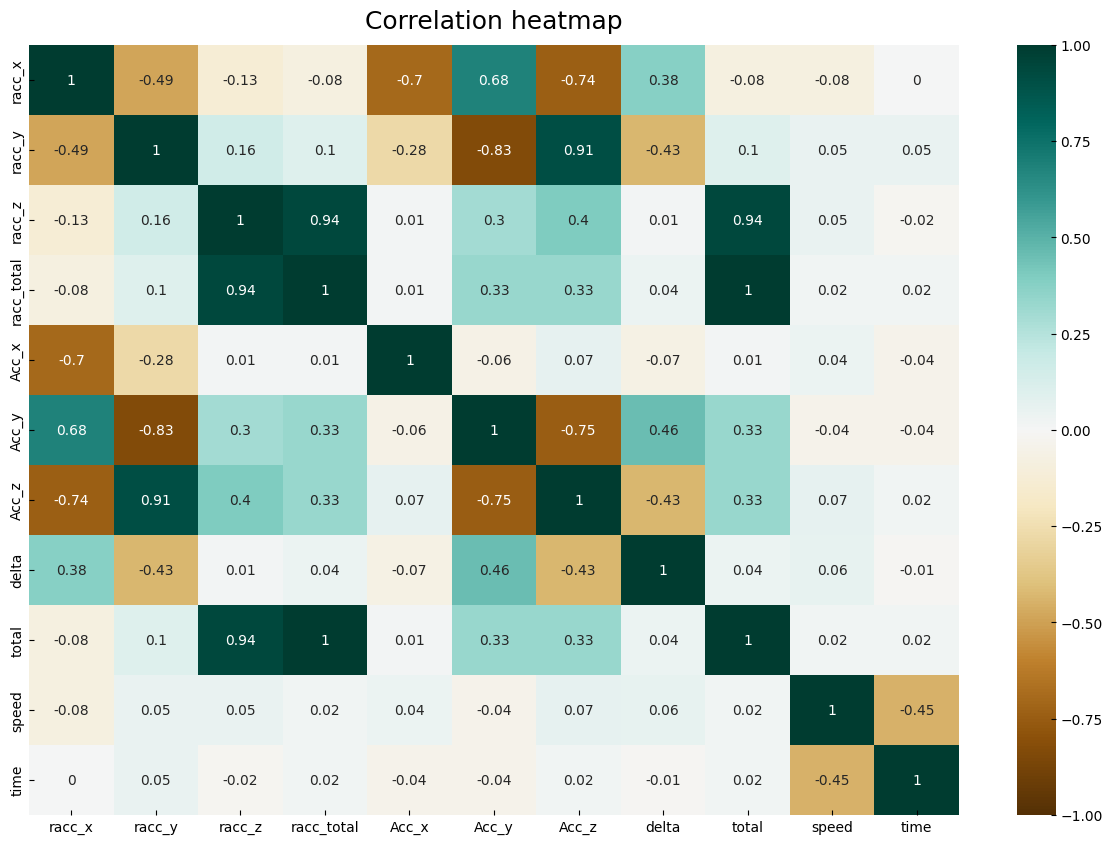

In [27]:
#correlation of parameters after reoreintation with yaw as a varible
plt.figure(figsize=(15,10))
correlations = dr_simple.corr()
heatmap= sns.heatmap(round(correlations,2), cmap='BrBG', annot=True, annot_kws={"size": 10}, vmin=-1, vmax=1)
heatmap.set_title('Correlation heatmap', fontdict={'fontsize':18}, pad= 12)
plt.grid(False)

# Brake detection

This algorithm detects a dramatic decline in a variable by comparing the value of the variable at each time step with a predefined threshold. When the value drops below the threshold, it signals a decline.

In [ ]:
data=dr[['racc_x','racc_y','delta']]

In [ ]:
data

,racc_x,racc_y,delta
0,0.360889,0.183381,0.000000e+00
1,-0.191719,0.197481,0.000000e+00
2,-0.249294,0.285308,0.000000e+00
3,-0.401734,0.236044,0.000000e+00
4,-0.537498,0.046148,1.312667e-01
...,...,...,...
6839,-0.163066,0.279909,6.996089e-10
6840,-0.166365,0.292078,0.000000e+00
6841,-0.220480,0.310206,0.000000e+00
6842,-0.201727,0.301724,0.000000e+00


In [ ]:
import pandas as pd

def detect_dramatic_decline(dataframe, window_size, threshold_factor):
    decline_indices = []
    decline_windows = []
    half_window_size = window_size // 2

    for i in range(half_window_size, len(dataframe) - half_window_size):
        window_start = i - half_window_size
        window_end = i + half_window_size

        window = dataframe.iloc[window_start:window_end + 1]
        moving_average = window.mean(axis=0)  # Specify axis=0 to calculate column-wise mean

        if (dataframe.iloc[i] < moving_average * threshold_factor).all():
            decline_indices.append(i)
            decline_windows.append(window)

    return decline_indices, decline_windows


In [ ]:
detect_dramatic_decline(data, 100, 5)

In [ ]:
import numpy as np

# Calculate the mean and standard deviation of your time series data
mean = np.mean(data,axis=0)
std = np.std(data)

# Calculate the Z-score for each data point
z_scores = (data - mean) / std

# Define a threshold for anomaly detection
threshold = 5.0  # Adjust as needed

# Find the indices of anomalies
anomaly_indices = np.where(np.abs(z_scores) > threshold)[0]

# Anomaly indices indicate the positions of anomalies in your data

In [ ]:
anomaly_indices

array([ 810,  814,  815,  816,  817,  818,  819, 2629, 2630, 2631, 2632,
       2633, 3333, 3336, 3337, 3344, 3443, 3496, 3497, 3498, 3549, 3628,
       3632, 4120, 4124, 4125, 4136, 5284, 5454, 5761, 5762, 5765, 5927,
       6443, 6734])

In [ ]:
data['speed']= dr['speed']
data['time']=dr['time']

In [ ]:
data

,racc_x,racc_y,racc_z,delta,speed,time
0,0.360889,0.183381,9.835386,0.000000e+00,0.000000e+00,0.0
1,-0.191719,0.197481,10.073603,0.000000e+00,0.000000e+00,0.1
2,-0.249294,0.285308,9.918085,0.000000e+00,0.000000e+00,0.2
3,-0.401734,0.236044,10.146700,0.000000e+00,1.445600e+01,0.3
4,-0.537498,0.046148,9.885395,1.312667e-01,1.454713e+01,0.4
...,...,...,...,...,...,...
6839,-0.163066,0.279909,9.836913,6.996089e-10,1.156800e-10,682.1
6840,-0.166365,0.292078,9.815238,0.000000e+00,0.000000e+00,682.2
6841,-0.220480,0.310206,9.832994,0.000000e+00,0.000000e+00,682.3
6842,-0.201727,0.301724,9.802847,0.000000e+00,0.000000e+00,682.4
